# Introduction

[RSGISLib](http://rsgislib.org) is a set of Python modules which have developed over the years to support our data processing needs.

The modules provide a set of high level functions, at a similar level to ArcGIS / QGIS toolbox functions or tools in ENVI or Erdas Imagine. The idea is that you can join a number of functions together to undertake your analysis or put those functions within a loop and process a number of input images.

This first tutorial will first show you how to calculate the [Normalised Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) in three ways:

 * Using the `rsgislib.imagecalc.calcindices.calc_ndvi` function - does everything in one function call :)
 * Using the `rsgislib.imagecalc.band_math` function - which is a very flexible way of doing simple data analysis
 * Using the `rsgislib.imagecalc.image_band_math` function - which is similar to `band_path` but can only use a single input image

In the second part of the tutorial you will look at using the `rsgislib.imagecalc.image_band_math` function to undertake a simple classification using the NDVI image you have calculated. However, the tutorial will start by getting some basic information for our input image and visualising it within the notebook.

NDVI is a useful indice for many vegetation studies and is also useful as it can be calculated from many different multi-spectral dataset:

$$
  \text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}}
$$


## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_


## Importing RSGISLib Modules

The first step is to import the modules from RSGISLib for the analysis we are to undertake:

In [1]:
# The highest level of the RSGISLib module which defines data types
# and a number of other constants.
import rsgislib

# The RSGISLib Image Calculations module which has the band_math
# and image_band_math functions.
import rsgislib.imagecalc

# The RSGISLib Image Indices module which can functions for simply
# calculating a number of standard remote sensing image indices
# and band ratios.
import rsgislib.imagecalc.calcindices

# The RSGISLib Image Utilities module
import rsgislib.imageutils

# The RSGISLib Raster GIS module
import rsgislib.rastergis

## Importing Other Modules

For visualising the results with a notebook there are other modules we need to import but if undertaking the analysis locally on your computer you can use your prefer data viewer (e.g., [TuiView](http://tuiview.org) or [QGIS](https://www.qgis.org))

In [2]:
# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline

import matplotlib.pyplot as plt

# Import the RSGISLib plotting module which has functions for helping
# to read and visualise image data within a plot for visualisation
# within a notebook.
import rsgislib.tools.plotting

## 1. Basic Image metadata

First you will query the input image to find the size (i.e., number of pixels in the x and y axis'), the image resolution, number of bands, band names, projection and get the spatial coordinates of the image bounding box.

In [3]:
# Define the input image path
input_img = "../data/sen2_20210527_aber.tif"

### 1.1. Image Size

In [4]:
# Call function to get the input image size:
x_size, y_size = rsgislib.imageutils.get_img_size(input_img)

# Output the x_size, y_size variables with some formatting
f"{x_size} x {y_size}"

'931 x 947'

### 1.2. Image Resolution

In [5]:
# Call function to get the input image resolution:
x_res, y_res = rsgislib.imageutils.get_img_res(input_img)


# Output the x_res, y_res variables with some formatting
f"({x_res}, {y_res})"

'(10.0, -10.0)'

### 1.3. Number of Image Bands

In [6]:
n_bands = rsgislib.imageutils.get_img_band_count(input_img)
f"Number of Bands: {n_bands}"

'Number of Bands: 10'

### 1.4. Image Band Names 

In [7]:
band_names = rsgislib.imageutils.get_band_names(input_img)

band_names

['Blue',
 'Green',
 'Red',
 'RE_B5',
 'RE_B6',
 'RE_B7',
 'NIR_B8',
 'NIR_B8A',
 'SWIR1',
 'SWIR2']

### 1.5. Image Projection

In [8]:
wkt_str = rsgislib.imageutils.get_wkt_proj_from_img(input_img)

# The image is projected using the British National Grid.
# The WKT string for this projection will be provided:

wkt_str

'PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","27700"]]'

In [9]:
epsg_code = rsgislib.imageutils.get_epsg_proj_from_img(input_img)

# The image is projected using the British National Grid.
# The EPSG code for the project should be outputted (27700):

epsg_code

27700

### 1.6. Spatial Boundary Box 

In [10]:
img_bbox = rsgislib.imageutils.get_img_bbox(input_img)

# The bbox is ordered as (min_x, max_x, min_y, max_y)

f"X: [{img_bbox[0]}, {img_bbox[1]}], Y: [{img_bbox[2]}, {img_bbox[3]}]"

'X: [257060.59483340546, 266370.59483340546], Y: [276258.7167059921, 285728.7167059921]'

## 2. Visualing the Input Image

Image Data Size: 931 x 947


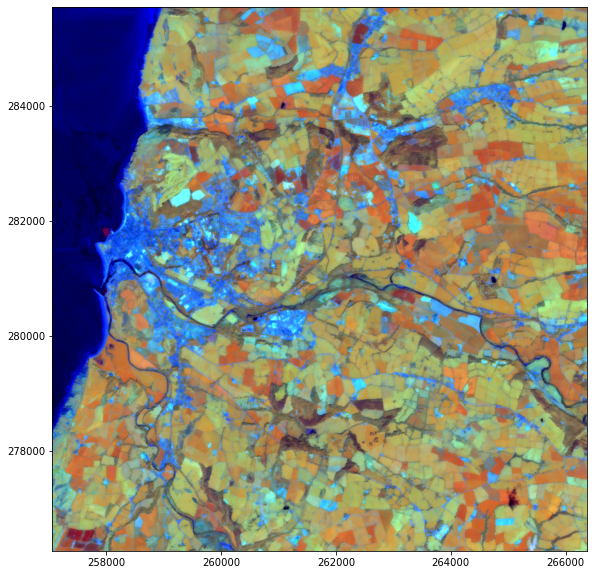

In [11]:
# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

## 3. Set GTIFF Output Options

We often use the KEA image file format (Bunting and Gillingham 2013) for which the default options are generally the ones you want - Note, the input image used in this example is a KEA file. However, GeoTIFF images are more widely supported by other applications 'out of the box' and therefore it is often useful to use GeoTIFF images where you do not need raster attribute tables (RAT). However, by default GeoTIFF doesn't compress or tile the data and we want to use this option. 

RSGISLib provides two helper functions to simplify setting the environmental variables for these options, we will use the LZW function for this analysis but the deflate function is also shown but commented out:


In [12]:
# Tile and compress the output GeoTIFF images using the LZW compression algorithm
rsgislib.imageutils.set_env_vars_lzw_gtiff_outs()

# Tile and compress the output GeoTIFF images using the Defalte compression algorithm
# rsgislib.imageutils.set_env_vars_deflate_gtiff_outs()

## 4. Calculating NDVI  using `calc_ndvi` Function


In [13]:
# The red band is band 3 - Note band numbering starts at 1.
img_red_band = 3

# The NIR band is band 8
img_nir_band = 8

# The output image file
ndvi_output_img = "sen2_20210527_aber_ndvi.tif"

# Specify that image metadata statistics and pyramids
# are to be calculated: calc_stats=True
# Specify that the output format should be
# GeoTIFF: gdalformat='GTIFF'
rsgislib.imagecalc.calcindices.calc_ndvi(
    input_img,
    img_red_band,
    img_nir_band,
    ndvi_output_img,
    calc_stats=True,
    gdalformat="GTIFF",
)

Image: ../data/sen2_20210527_aber.tif
	 Variable 'red' is band 3
	 Variable 'nir' is band 8
New image width = 931 height = 947 bands = 1



Calculating Image Pyramids.




### Visualise the NDVI result:

Image Data Size: 931 x 947


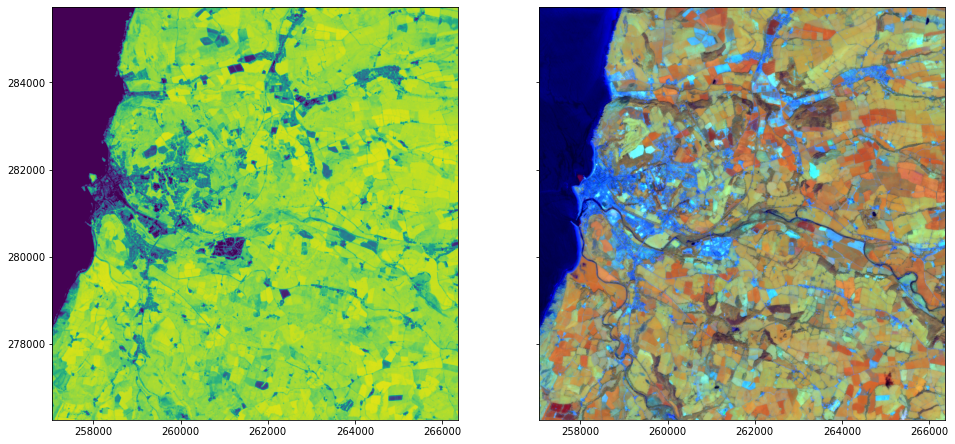

In [14]:
# Get the image data - the NDVI image will have just a single image band.
img_ndvi_data, img_ndvi_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    ndvi_output_img
)

# Stretch the data for better visualisation
img_ndvi_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_ndvi_data, no_data_val=-999
)

# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_ndvi_data_strch, extent=img_ndvi_coords)
ax2.imshow(img_data_strch, extent=img_coords)

## 5. Calculating NDVI using `band_math` Function

To illustraing how to use the `rsgislib.imagecalc.band_math` function NDVI can also be calculated using the following code. However, note this function does not deal with no data values within the input image as the `calc_ndvi` does.

The `rsgislib.imagecalc.band_math` function is a flexible function which has lots of uses for data analysis where the pixel value can be calculated from other pixels (e.g., applying an equation).


In [15]:
# The output image file
ndvi_tmp_output_img = "sen2_20210527_aber_ndvi_tmp.tif"

# Define the image bands to variable names to be used within expression
band_defns = list()
band_defns.append(rsgislib.imagecalc.BandDefn("red", input_img, 3))
band_defns.append(rsgislib.imagecalc.BandDefn("nir", input_img, 8))

# Expression
exp = "(nir-red)/(nir+red)"

# Run the band maths function
rsgislib.imagecalc.band_math(
    ndvi_tmp_output_img, exp, "GTIFF", rsgislib.TYPE_32FLOAT, band_defns
)

# Calculate the meta-data statistics and image pyramids as we have not dealt with no data values
# in the NDVI equation above then we do not have a define no data value to set here:
rsgislib.imageutils.pop_img_stats(
    ndvi_tmp_output_img, use_no_data=False, no_data_val=0, calc_pyramids=True
)

Image: ../data/sen2_20210527_aber.tif
	 Variable 'red' is band 3
	 Variable 'nir' is band 8
New image width = 931 height = 947 bands = 1



Calculating Image Pyramids.




### Visual NDVI result:

Image Data Size: 931 x 947


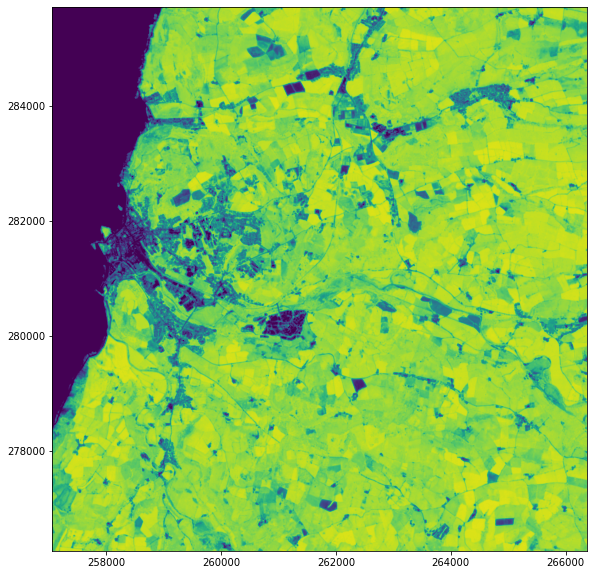

In [16]:
# Get the image data - the NDVI image will have just a single image band.
img_ndvi_tmp_data, img_ndvi_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    ndvi_tmp_output_img
)

# Stretch the data for better visualisation
img_ndvi_tmp_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_ndvi_tmp_data, no_data_val=-999
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_ndvi_tmp_data_strch, extent=img_ndvi_coords)

## 6. Calculating NDVI using `image_band_math` Function:

The `rsgislib.imagecalc.image_band_math` function is similar to the `rsgislib.imagecalc.band_math` function but only use a single input image where the image bands are referred to as `b1` (band 1), `b2` (band 2), ..., `bn` (band n) within the expression. Please note that band numbering starts at 1. 


In [17]:
# The output image file
ndvi_tmp_output_img = "sen2_20210527_aber_ndvi_tmp.tif"

# Expression
exp = "(b8-b3)/(b8+b3)"

# Run the band maths function
rsgislib.imagecalc.image_band_math(
    input_img, ndvi_tmp_output_img, exp, "GTIFF", rsgislib.TYPE_32FLOAT
)

# Calculate the meta-data statistics and image pyramids as we have not dealt with no data values
# in the NDVI equation above then we do not have a define no data value to set here:
rsgislib.imageutils.pop_img_stats(
    ndvi_tmp_output_img, use_no_data=False, no_data_val=0, calc_pyramids=True
)

New image width = 931 height = 947 bands = 1



Calculating Image Pyramids.




### Visual NDVI result:

Image Data Size: 931 x 947


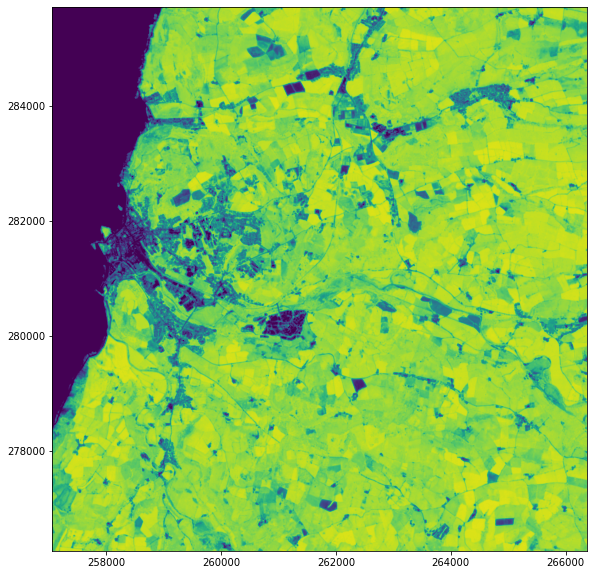

In [18]:
# Get the image data - the NDVI image will have just a single image band.
img_ndvi_tmp_data, img_ndvi_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    ndvi_tmp_output_img
)

# Stretch the data for better visualisation
img_ndvi_tmp_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_ndvi_tmp_data, no_data_val=-999
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_ndvi_tmp_data_strch, extent=img_ndvi_coords)

## 7. Threshold the NDVI into a simple set of classes

The `band_math` and `image_band_math` function both use the muparser library to parse the expressions passed to the function. [Muparser has the build-in functions](https://beltoforion.de/en/muparser/features.php#idDef1) you could expect of most calculators (e.g., sin, cos, log etc.) but it also has the ability calculate a minimum, maxium and average from a list of input values. However, muparser also has an option to apply an [if-else expression](https://beltoforion.de/en/muparser/features.php#idDef3) and can use [binary operators (e.g., or, and, not.)](https://beltoforion.de/en/muparser/features.php#idDef2) to join expressions together. We will use this functionality to build a basic classification using the NDVI. 

However, first we need to understand the [if-else expression](https://beltoforion.de/en/muparser/features.php#idDef3) syntax of muparser:

> `<expression>?<true value>:<false value>`

> `if <expression> then <true value> else <false value>`

So, if we wanted to use our NDVI to classify vegetated verses non-vegetated pixels then we might use an expression such as:

> `ndvi>0.3?1:2`

In this case pixels with an NDVI greater than 0.3 will be given the pixel value 1 (i.e., the vegetated class) and pixels with a value less or equal to 0.3 will be given a pixel value of 2 (i.e., non-vegetation class). 

We can combine [if-else expressions](https://beltoforion.de/en/muparser/features.php#idDef3) to increase the number of classes to be produced. For example, in the following code we will introduce a highly productive vegetation class for pixels with an NDVI greater than 0.65:

> `ndvi<=0.3?2:ndvi>0.65?3:1`

The expression above contains the following logic: If the NDVI is less than or equal to 0.3 output a pixel value of 2 (i.e., non-vegetated), else if the NDVI is greater than 0.65 then output a pixel value of 3 (i.e., highly productive vegetation) else output a pixel value of 1 (i.e., less productive vegetation). 

You could keep adding else statments to increate the number of classes within your output classification.

The expression above could also be written using the binary operator `and` as follows:

> `(ndvi>0.3)&&(ndvi<=0.65)?1:ndvi<=0.3?2:3`

The expression above contains the following logic but will produce the same result as the expression above: If the NDVI is greater than 0.3 and less than or equal to 0.65 then output a pixel value of 1 (i.e., less productive vegetation), if the NDVI has a value of less than or equal to 0.3 then output a pixel value of 2 (i.e., non-vegetated) otherwise output a value of 3 (i.e., highly productive vegetation) which must have a pixel value greater than 0.65.


In [19]:
# The output image file - we will use the KEA output format
#  as we can then write the class names to the image attribute
# table so the user knows what the different pixel values
# relate to.
ndvi_cls_output_img = "sen2_20210527_aber_ndvi_cls.kea"

# Define the image bands to variable names to be used within expression
# in this case we only have a single band within the image file so using
# the band_math function isn't really needed but it can be helpful in
# using a named variable in the expression so you know what it refers to.
# In this case, we can shorten the syntax so rather than creating a list
# and then appending the BandDefn objects we can just create the list
# with a single BandDefn object within the list.
band_defns = [rsgislib.imagecalc.BandDefn("ndvi", ndvi_output_img, 1)]

# Expression
exp = "ndvi<=0.65?2:ndvi>0.85?3:1"

# Run the band maths function. Note we have changed the output
# format to KEA and the output data type to an 8bit unsigned
# integer (i.e., whole numbers with a range of 0 - 255).
rsgislib.imagecalc.band_math(
    ndvi_cls_output_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns
)

# Similar to when we calculated the NDVI we want to
# populate the output image to meta-data statistics
# and calculate pyramids. As this is a thematic output
# rather than contiuous we will use a different function.
# In this case we will use the pop_rat_img_stats function
#  which is most appropriate for image formats with support
# raster attribute tables (RAT; i.e., KEA or HFA). if you
# were to output a GTIFF or similar format then you would
# use the rsgislib.imageutils.pop_thmt_img_stats function
#  to calculate appropriate thematic meta-data and pyramids.
rsgislib.rastergis.pop_rat_img_stats(
    clumps_img=ndvi_cls_output_img,
    add_clr_tab=True,
    calc_pyramids=True,
    ignore_zero=True,
)


# Define colours for the classes to they are useful
# for interpretting the classification. The colours
# are defined with a Red, Green, Blue value between
# 0 - 255. If you search "colour picker" in your
# preferred search engine then you will find
# various online tools for finding the RGB values
# for a colour.
clr_lut = dict()
clr_lut[1] = [22, 140, 34]
clr_lut[2] = [163, 163, 163]
clr_lut[3] = [115, 242, 36]
rsgislib.imageutils.define_colour_table(ndvi_cls_output_img, clr_lut)

Image: sen2_20210527_aber_ndvi.tif
	 Variable 'ndvi' is band 1
New image width = 931 height = 947 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Image Data Size: 931 x 947


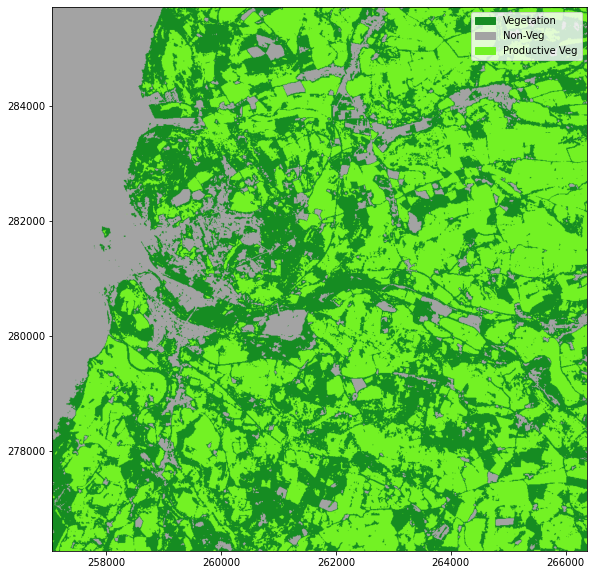

In [20]:
# Define a look up table (LUT) for the class names
# to be used to generate the legend for the map.
cls_names_lut = dict()
cls_names_lut[1] = "Vegetation"
cls_names_lut[2] = "Non-Veg"
cls_names_lut[3] = "Productive Veg"


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_data,
    img_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    ndvi_cls_output_img, out_patches=True, cls_names_lut=cls_names_lut
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data, extent=img_coords)

# Add the legend to the plot using the patches from the
# get_gdal_thematic_raster_mpl_imshow function.
ax.legend(handles=lgd_patches)